Example for an infinite Gaussian mixture

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pred_coreset as pc
import scipy as sp
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
import arviz  as az
import seaborn as sns
import torch
import ot

Generate data from a mixture

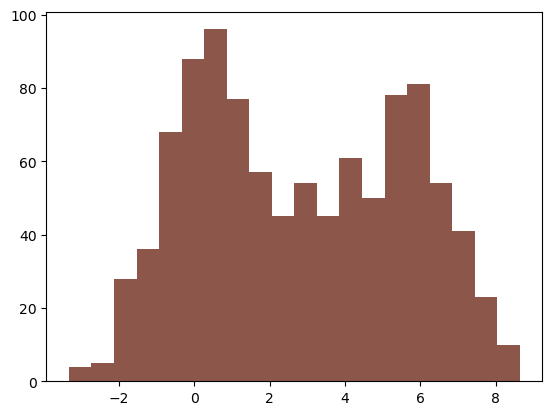

In [3]:
np.random.seed(1428) #set seed

pis = np.array([0.3, 0.4, 0.3]) #probs of mixture
thetas = np.array([[0.0,1], [3.0,2], [6.0,1]]) #params of mixtures, it stacks them veritcally
#initialize array
x = np.random.normal(thetas[0,0], thetas[0,1])
for i in range(1000):
    #choose which kernel to sample from
    k = np.random.choice(range(3), p=pis)
    #sample and append
    x = np.vstack((x, np.random.normal(thetas[k,0], thetas[k,1])))

#check resulting empirical
plt.hist(x, bins=20, color="C5")
plt.show()

# join it
x = np.squeeze(x)

Now let's fit a DPM model using scikit-learn

In [4]:
# Fit a Dirichlet process mixture of Gaussians using 7 components
alpha = 1.0
K = 7
N = x.shape[0] #sample size

def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    w = pm.Dirichlet("w", np.repeat(alpha / K, K), dims = "component")
    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=tau, dims="component", initval=list(range(K)))
    obs = pm.NormalMixture(
        "obs", w, mu, tau, observed=x, dims="obs_id"
    )

with model:
    inference = pm.fit(300,
                            method="svgd",
                            inf_kwargs=dict(n_particles=1000),
                            obj_optimizer=pm.sgd(learning_rate=0.01),)



Pre processing for the density plot

In [5]:
mu_tot = inference.sample(1000).posterior["mu"].values.mean(axis=1).flatten()
sigma_tot = 1.0/np.sqrt(inference.sample(1000).posterior["tau"].values).mean(axis=1).flatten()
w_tot = inference.sample(1000).posterior["w"].values.mean(axis=1).flatten()

pdf_tot =np.vectorize( lambda x: sum( [w_tot[i] * sp.stats.norm(loc=mu_tot[i], scale=sigma_tot[i]).pdf(x) for i in range(7)]))

Now let's find a coreset

In [8]:
import mixt_sampler as mixt

<function Tensor.size>

In [18]:
core_x =  torch.from_numpy(x[torch.randint(0, len(x), (50,))])

ws = pc.get_coreset(torch.from_numpy(x), 500, core_x, 1, mixt.mixt, 1, dc.Discrepancy(ot.dist, p=2), parallel = True)

100%|██████████| 500/500 [00:00<00:00, 3495253.33it/s]


In [26]:
w_mean = torch.mean(ws, dim=1)

Now fit the mixture on the uniform subsample

In [12]:
N = core_x.shape[0] #sample size

with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model_unif:
    w = pm.Dirichlet("w", np.repeat(alpha / K, K), dims = "component")
    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=tau, dims="component",transform = pm.distributions.transforms.ordered,  initval=list(range(K)))
    
    obs = pm.NormalMixture(
        "obs", w, mu, tau, observed=core_x, dims="obs_id"
    )

with model_unif:
    inference_unif = pm.fit(600,
                            method="svgd",
                            inf_kwargs=dict(n_particles=1000),
                            obj_optimizer=pm.sgd(learning_rate=0.01),
    )


Now with the coreset

In [27]:
N = core_x.shape[0] #sample size

with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model_core:
   # beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Dirichlet("w", np.repeat(alpha / K, K), dims = "component")
    #w = pm.Deterministic("w", stick_breaking(beta)/sum(stick_breaking(beta)), dims="component")
    tau = pm.Gamma("tau", 0.5, 0.5, dims="component")
    mu = pm.Normal("mu", 0, tau=tau, dims="component", transform = pm.distributions.transforms.ordered, initval=list(range(K)))
    obs = pm.NormalMixture(
        "obs", w, mu, tau, observed= w_mean.detach()*core_x, dims="obs_id"
    )

with model_core:
    inference_core = pm.fit(600,
                            method="svgd",
                            inf_kwargs=dict(n_particles=1000),
                            obj_optimizer=pm.sgd(learning_rate=0.01),
        )


Pre processing for the plots

In [14]:
mu_unif = inference_unif.sample(1000).posterior["mu"].values.mean(axis=1).flatten()
sigma_unif = 1.0/np.sqrt(inference_unif.sample(1000).posterior["tau"].values).mean(axis=1).flatten()
w_unif = inference_unif.sample(1000).posterior["w"].values.mean(axis=1).flatten()

pdf_unif =np.vectorize( lambda x: sum([w_unif[i]* sp.stats.norm(loc=mu_unif[i], scale=sigma_unif[i]).pdf(x) for i in range(7)]))

In [28]:
mu_core = inference_core.sample(1000).posterior["mu"].values.mean(axis=1).flatten()
sigma_core = 1.0/np.sqrt(inference_core.sample(1000).posterior["tau"].values).mean(axis=1).flatten()
w_core = inference_core.sample(1000).posterior["w"].values.mean(axis=1).flatten()

pdf_core =np.vectorize( lambda x: sum([w_core[i] * sp.stats.norm(loc=mu_core[i], scale=sigma_core[i]).pdf(x) for i in range(7)]))

/opt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


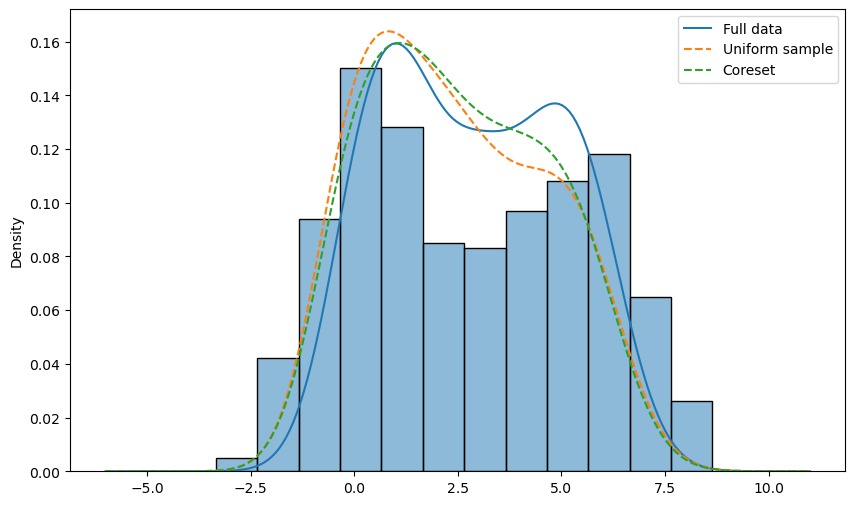

In [29]:
x_plot = np.linspace(-6, 11, 200)

plt.figure(figsize=(10, 6))
sns.histplot(x, alpha=0.5, stat="density")
plt.plot(x_plot, pdf_tot(x_plot), '-', label='Full data')
plt.plot(x_plot, pdf_unif(x_plot), '--', label='Uniform sample')
plt.plot(x_plot, pdf_core(x_plot), '--', label='Coreset')
plt.legend()

In [30]:
sp.stats.entropy(pdf_tot(x_plot), pdf_core(x_plot))-sp.stats.entropy(pdf_tot(x_plot), pdf_unif(x_plot))

-0.004277093533489297